## 0.1 🌐 Connect to Google Colab

In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  print("Google Drive connected successfully!")
  import os
  os.chdir('/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project')
except:
  print("Google Drive not connected!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive connected successfully!


## 0.2 📦 Install Essential Libraries

In [2]:
# Type the version of cv2
import cv2
cv2.__version__

'4.11.0'

In [3]:
# =============================== #
# 📌 Standard Library Imports
# =============================== #
import os
import sys
import glob
import shutil
import time
import datetime
import random
import warnings

# =============================== #
# 📌 Numerical & Data Handling
# =============================== #
import numpy as np
import pandas as pd

# =============================== #
# 📌 Image Processing Libraries
# =============================== #
import cv2
from PIL import Image

# =============================== #
# 📌 Deep Learning & Model Handling
# =============================== #
import tensorflow as tf
import tensorflow.lite as tflite
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from scipy.spatial.distance import cosine

# ONNX Conversion Libraries
try:
    import onnx
except ImportError:
    print("Installing ONNX...")
    !pip install onnx
    import onnx

try:
    import tf2onnx
except ImportError:
    print("Installing tf2onnx...")
    !pip install tf2onnx
    import tf2onnx

# =============================== #
# 📌 Data Science & Visualization
# =============================== #
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# =============================== #
# 📌 Interactive & Console Utilities
# =============================== #
from IPython.display import display
from rich.console import Console
from rich.table import Table
from rich.progress import track
from rich import print as rprint
from tqdm import tqdm

# =============================== #
# 📌 PyTorch (For additional tasks)
# =============================== #
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# =============================== #
# 📌 Machine Learning Utilities
# =============================== #
from sklearn.model_selection import train_test_split

import sqlite3


# =============================== #
# ⚠️ Suppress Warnings
# =============================== #
warnings.filterwarnings("ignore")

##  0.3 ⚙️ Setup the device

In [4]:
def setup_device():
    try:
        device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
        print(f"⚙️ Running on: {device}")
        return device
    except Exception as e:
        print(f"❌ Error setting up device: {e}")


In [5]:
device = setup_device()

⚙️ Running on: CPU


## 0.4 Adjust Pathes

In [6]:
# ✅ Define Directories
RAW_DATA_PATH = "data/raw/"
PROCESSED_DATA_PATH = "data/processed/"
CUSTOME_IMAGES_PATH = "/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/data/CustomeImages"

# ✅ Create processed data directory if not exists
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

# ✅ Load Face Detection Model
# 📝 Model structure file
prototxt_path  = "/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/models/deploy.prototxt"
# 🏋️‍♂️ Pre-trained model file
model_path  = "/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/models/res10_300x300_ssd_iter_140000.caffemodel"

# Get the models
chechpoint_path = "/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/models/InceptionV3_checkpoint.weights.h5"
h5_model_path = "/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/models/InceptionV3_model.h5"
keras_model_path = "/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/models/InceptionV3_model.keras"


## 0.5 Build our FaceDetector

In [7]:
class FaceDetector:
    """ 🚀 Face Detection & Preprocessing Pipeline using OpenCV's DNN module. """

    def __init__(self, prototxt_path, model_path, confidence_threshold=0.5):
        try:
            self.model = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)
            self.confidence_threshold = confidence_threshold
        except Exception as e:
            print(f"Error loading model: {e}")

    def detect_faces(self, image):
        h, w = image.shape[:2]
        blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300),
                                     mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
        self.model.setInput(blob)
        detections = self.model.forward()

        faces = []
        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > self.confidence_threshold:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (x, y, x_max, y_max) = box.astype("int")
                x, y = max(0, x), max(0, y)
                x_max, y_max = min(w, x_max), min(h, y_max)

                if x_max > x and y_max > y:
                    face = image[y:y_max, x:x_max]
                    faces.append(face)
        return faces

    def preprocess_image(self, image):
        """ Convert image to RGB and resize """
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = cv2.resize(image, (299, 299))
        image = image.astype("float32") / 255.0  # Normalize
        return image

    def process_and_save_faces(self, image_path, save_path, show=False):
        """ Detect faces, preprocess, augment, and save them """
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert once for visualization

        faces = self.detect_faces(image)

        if not faces:
            print("⚠️ No faces detected in image.")
            return

        for i, face in enumerate(faces):
            processed_face = self.preprocess_image(face)

            if show:
                print(f"Displaying face {i+1} in RGB format:")
                plt.imshow(processed_face)  # Should display the image in RGB
                plt.axis('off')
                plt.show()

            # Save the processed face
            save_name = f"{save_path}/processed_face_{i}.png"
            processed_rgb = cv2.cvtColor((processed_face * 255).astype("uint8"), cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
            cv2.imwrite(save_name, processed_rgb)


In [8]:
# ✅ Initialize Face Detector
face_detector = FaceDetector(prototxt_path, model_path)

##0.6 Load the model

In [9]:
from tensorflow.keras.models import load_model

# 🔹 Load the model from .keras format
loaded_model_keras = load_model(keras_model_path)
print("✅ Keras model loaded successfully!")

# 🔹 Load the model from .h5 format
loaded_model_h5 = load_model(h5_model_path)
print("✅ H5 model loaded successfully!")

# 🔹 Check model summary
loaded_model_keras.summary()

✅ Keras model loaded successfully!


✅ H5 model loaded successfully!


Model: "InceptionV3_FaceRec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 26,197,236 (99.93 MB)

 Trainable params: 3,164,009 (12.07 MB)

 Non-trainable params: 19,869,216 (75.80 MB)

 Optimizer params: 3,164,011 (12.07 MB)

# **2. Test our model on the custome data**

In [ ]:
Classes = {
    'pins_Adriana Lima': 0, 'pins_Alex Lawther': 1, 'pins_Alexandra Daddario': 2, 'pins_Alvaro Morte': 3, 'pins_Amanda Crew': 4,
    'pins_Andy Samberg': 5, 'pins_Anne Hathaway': 6, 'pins_Anthony Mackie': 7, 'pins_Avril Lavigne': 8, 'pins_Ben Affleck': 9,
    'pins_Bill Gates': 10, 'pins_Bobby Morley': 11, 'pins_Brenton Thwaites': 12, 'pins_Brian J. Smith': 13, 'pins_Brie Larson': 14,
    'pins_Chris Evans': 15, 'pins_Chris Hemsworth': 16, 'pins_Chris Pratt': 17, 'pins_Christian Bale': 18, 'pins_Cristiano Ronaldo': 19,
    'pins_Danielle Panabaker': 20, 'pins_Dominic Purcell': 21, 'pins_Dwayne Johnson': 22, 'pins_Eliza Taylor': 23, 'pins_Elizabeth Lail': 24,
    'pins_Emilia Clarke': 25, 'pins_Emma Stone': 26, 'pins_Emma Watson': 27, 'pins_Gwyneth Paltrow': 28, 'pins_Henry Cavil': 29,
    'pins_Hugh Jackman': 30, 'pins_Inbar Lavi': 31, 'pins_Irina Shayk': 32, 'pins_Jake Mcdorman': 33, 'pins_Jason Momoa': 34,
    'pins_Jennifer Lawrence': 35, 'pins_Jeremy Renner': 36, 'pins_Jessica Barden': 37, 'pins_Jimmy Fallon': 38, 'pins_Johnny Depp': 39,
    'pins_Josh Radnor': 40, 'pins_Katharine Mcphee': 41, 'pins_Katherine Langford': 42, 'pins_Keanu Reeves': 43, 'pins_Krysten Ritter': 44,
    'pins_Leonardo DiCaprio': 45, 'pins_Lili Reinhart': 46, 'pins_Lindsey Morgan': 47, 'pins_Lionel Messi': 48, 'pins_Logan Lerman': 49,
    'pins_Madelaine Petsch': 50, 'pins_Maisie Williams': 51, 'pins_Maria Pedraza': 52, 'pins_Marie Avgeropoulos': 53, 'pins_Mark Ruffalo': 54,
    'pins_Mark Zuckerberg': 55, 'pins_Megan Fox': 56, 'pins_Miley Cyrus': 57, 'pins_Millie Bobby Brown': 58, 'pins_Morena Baccarin': 59,
    'pins_Morgan Freeman': 60, 'pins_Nadia Hilker': 61, 'pins_Natalie Dormer': 62, 'pins_Natalie Portman': 63, 'pins_Neil Patrick Harris': 64,
    'pins_Pedro Alonso': 65, 'pins_Penn Badgley': 66, 'pins_Rami Malek': 67, 'pins_Rebecca Ferguson': 68, 'pins_Richard Harmon': 69,
    'pins_Rihanna': 70, 'pins_Robert De Niro': 71, 'pins_Robert Downey Jr': 72, 'pins_Sarah Wayne Callies': 73, 'pins_Selena Gomez': 74,
    'pins_Shakira Isabel Mebarak': 75, 'pins_Sophie Turner': 76, 'pins_Stephen Amell': 77, 'pins_Taylor Swift': 78, 'pins_Tom Cruise': 79,
    'pins_Tom Hardy': 80, 'pins_Tom Hiddleston': 81, 'pins_Tom Holland': 82, 'pins_Tuppence Middleton': 83, 'pins_Ursula Corbero': 84,
    'pins_Wentworth Miller': 85, 'pins_Zac Efron': 86, 'pins_Zendaya': 87, 'pins_Zoe Saldana': 88, 'pins_alycia dabnem carey': 89,
    'pins_amber heard': 90, 'pins_barack obama': 91, 'pins_barbara palvin': 92, 'pins_camila mendes': 93, 'pins_elizabeth olsen': 94,
    'pins_ellen page': 95, 'pins_elon musk': 96, 'pins_gal gadot': 97, 'pins_grant gustin': 98, 'pins_jeff bezos': 99, 'pins_kiernen shipka': 100,
    'pins_margot robbie': 101, 'pins_melissa fumero': 102, 'pins_scarlett johansson': 103, 'pins_tom ellis': 104
}

In [ ]:
def process_and_predict(image_path, face_detector, loaded_model_keras, Classes):
    image = cv2.imread(image_path)

    # Detect faces
    faces = face_detector.detect_faces(image)

    predictions = []  # List to hold prediction results

    for i, face in enumerate(faces):
        # Preprocess the face image for prediction
        processed_face = face_detector.preprocess_image(face)
        if processed_face is not None:
            # Predict using the loaded model
            face_array = np.expand_dims(processed_face, axis=0)  # Add batch dimension
            prediction = loaded_model_keras.predict(face_array)
            predicted_class_index = np.argmax(prediction)  # Get the index of the highest probability
            predicted_class_name = [key for key, value in Classes.items() if value == predicted_class_index][0]

            predictions.append(predicted_class_name)  # Append the class name instead of index

            # Show the processed face with matplotlib
            plt.imshow(processed_face)  # Display RGB image
            plt.title(f"Prediction: {predicted_class_name}")
            plt.axis('off')  # Hide axes
            plt.show()

    return predictions

Processing Images:   0%|          | 0/17 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


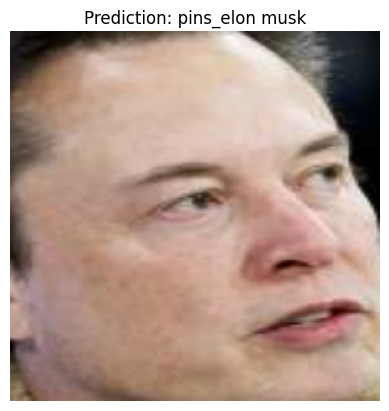

Processing Images:   6%|▌         | 1/17 [00:00<00:08,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


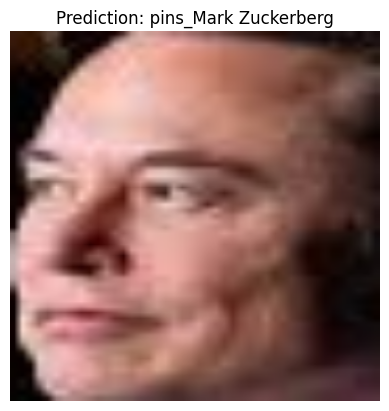

Processing Images:  12%|█▏        | 2/17 [00:01<00:07,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


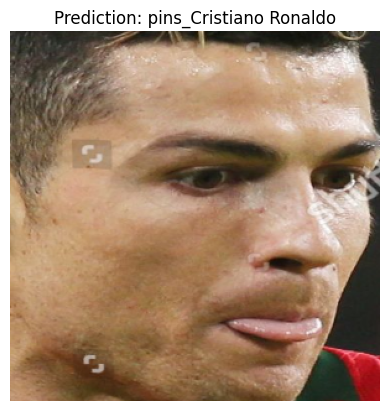

Processing Images:  18%|█▊        | 3/17 [00:01<00:07,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


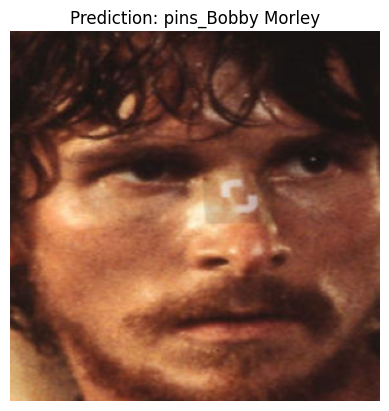

Processing Images:  24%|██▎       | 4/17 [00:02<00:07,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


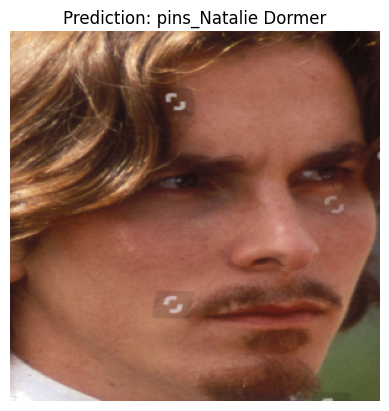

Processing Images:  29%|██▉       | 5/17 [00:02<00:06,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


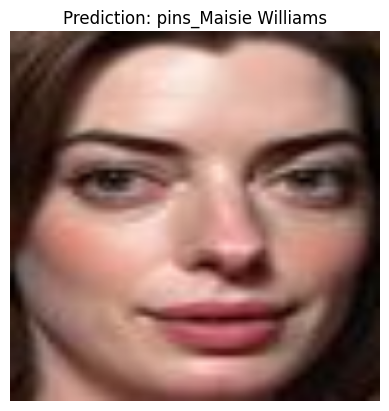

Processing Images:  35%|███▌      | 6/17 [00:03<00:06,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


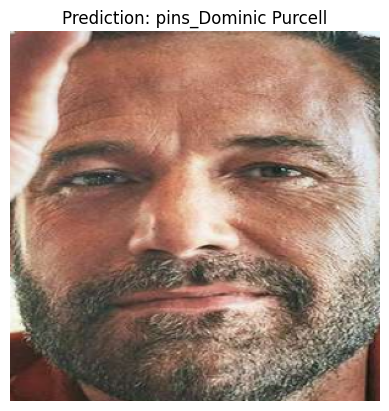

Processing Images:  41%|████      | 7/17 [00:03<00:05,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


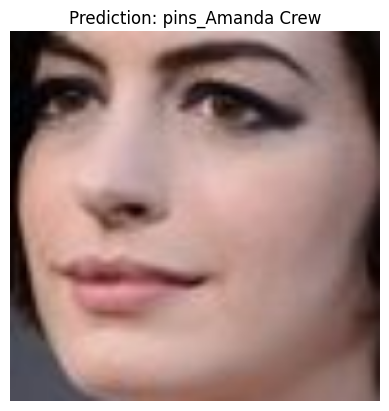

Processing Images:  47%|████▋     | 8/17 [00:04<00:05,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


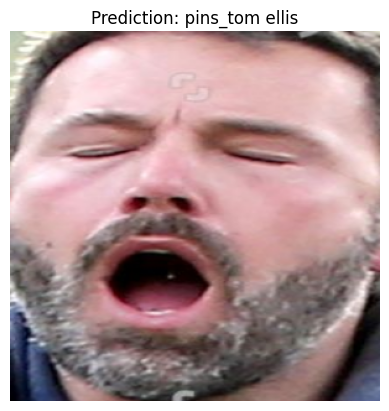

Processing Images:  53%|█████▎    | 9/17 [00:05<00:04,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


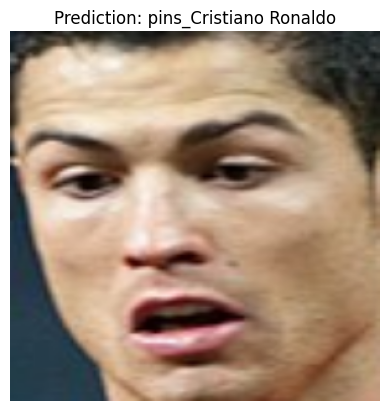

Processing Images:  59%|█████▉    | 10/17 [00:05<00:04,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


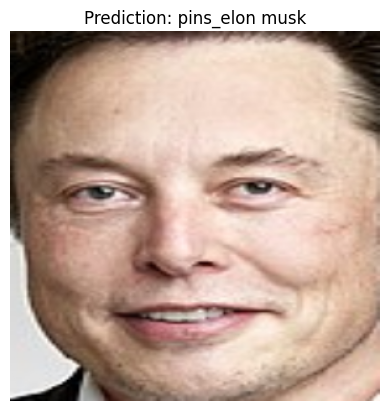

Processing Images:  65%|██████▍   | 11/17 [00:06<00:03,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


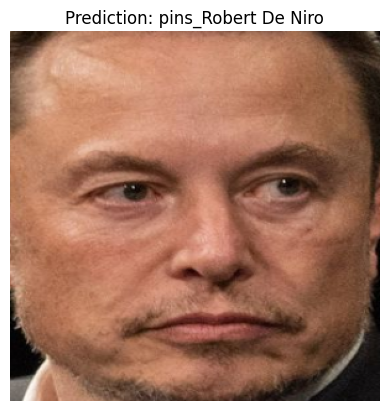

Processing Images:  71%|███████   | 12/17 [00:06<00:02,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


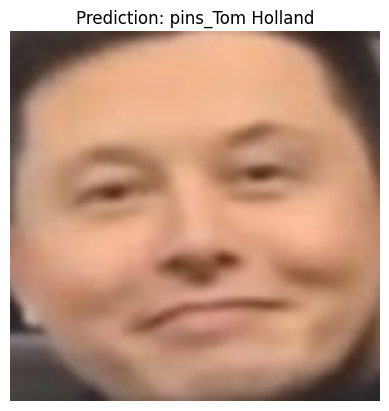

Processing Images:  76%|███████▋  | 13/17 [00:07<00:02,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


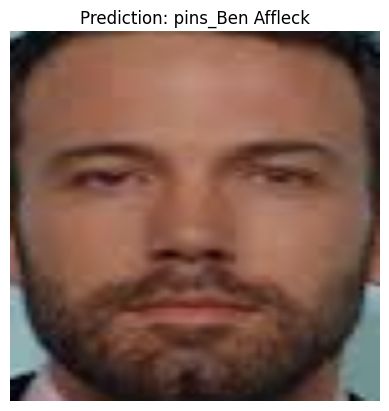

Processing Images:  82%|████████▏ | 14/17 [00:08<00:01,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


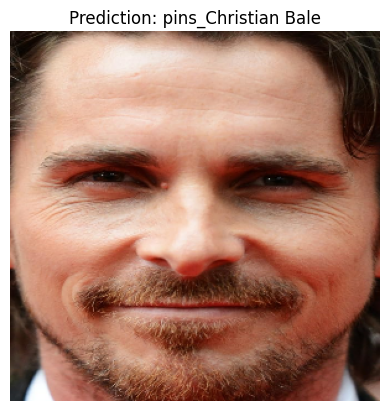

Processing Images:  88%|████████▊ | 15/17 [00:08<00:01,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


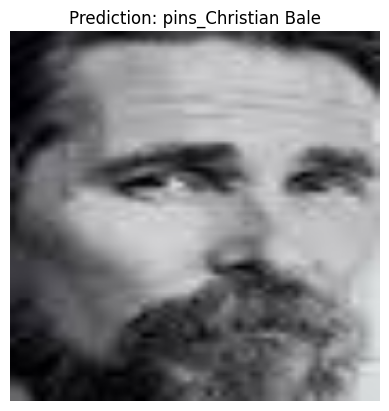

Processing Images:  94%|█████████▍| 16/17 [00:09<00:00,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


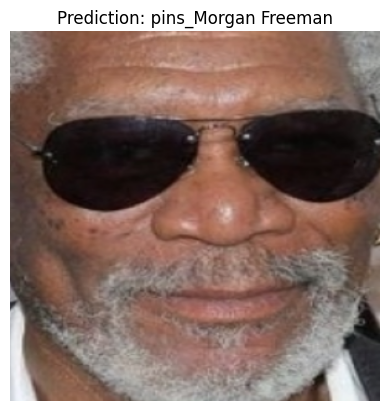

Processing Images: 100%|██████████| 17/17 [00:09<00:00,  1.72it/s]


In [ ]:
# Iterate through all images in the custom dataset
image_paths = [os.path.join(CUSTOME_IMAGES_PATH, img) for img in os.listdir(CUSTOME_IMAGES_PATH) if img.endswith(('jpg', 'jpeg', 'png'))]

for image_path in tqdm(image_paths, desc="Processing Images"):
  process_and_predict(image_path, face_detector, loaded_model_keras, Classes)

In [12]:
def load_image(image_path):
    """Loads an image from a given path and converts it to RGB."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if image is None:
        raise FileNotFoundError(f"Error: Image not found at {image_path}")
    return image

In [13]:
def preprocess_face(image):
    """Preprocesses the face image to fit InceptionV3 input requirements."""
    faces = face_detector.detect_faces(image)
    if len(faces) == 0:
        raise ValueError("No face detected in the image.")
    processed_face = face_detector.preprocess_image(faces[0])
    processed_face = np.expand_dims(processed_face, axis=0)
    img = preprocess_input(processed_face)
    return img


In [14]:
def get_embedding(model, face_image):
    """Extracts a 2048-d feature vector from the face image using InceptionV3."""
    processed_face = preprocess_face(face_image)
    embedding = model.predict(processed_face)[0]  # Get feature vector
    return embedding

In [15]:
from sklearn.preprocessing import normalize

def compare_faces(embedding1, embedding2, threshold=0.8):
    """Compares two face embeddings using cosine similarity and determines if they match."""
    embedding1 = normalize([embedding1])[0]
    embedding2 = normalize([embedding2])[0]
    similarity = 1 - cosine(embedding1, embedding2)
    is_match = similarity >= threshold
    return is_match, similarity


In [41]:
def recognize_face(known_faces, known_names, test_face, model, threshold=0.8):
    """Compares a test face against known faces and returns the recognized name or 'Non-Defined'."""
    test_embedding = get_embedding(model, test_face)
    best_match = ('Non-Defined', 0)  # Default: No match

    for name, known_embedding in zip(known_names, known_faces):
        is_match, similarity = compare_faces(known_embedding, test_embedding, threshold)

        if is_match and similarity > best_match[1]:
            best_match = (name, similarity)

    if best_match[1] < threshold + 0.1:  # Adding margin to avoid false positives
        return 'Non-Defined'

    return best_match[0]

In [17]:
def visualize_recognition(test_face, recognized_name):
    """Displays the test face image with the recognized name."""
    plt.figure(figsize=(4, 4))
    plt.imshow(test_face)
    plt.title(f"Recognized: {recognized_name}", fontsize=12)
    plt.axis('off')
    plt.show()

In [18]:
def show_detected_face(image_path, faces):
    """Visualizes the detected face bounding boxes on the image."""
    image = cv2.imread(image_path)  # Load the image

    # Check if faces is empty or has unexpected format
    if not faces or not isinstance(faces[0], np.ndarray):
        print("⚠️ No faces detected or unexpected format.")
        return

    # Assuming faces contains a list of image arrays, visualize the first one
    plt.imshow(cv2.cvtColor(faces[0], cv2.COLOR_BGR2RGB))
    plt.title("Detected Face")
    plt.axis('off')
    plt.show()

In [19]:
# Load test face image
reference_image_path1 = "/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/data/CustomeImages/GettyImages-1258889149-1f50bb87f9d54dca87813923f12ac94b.jpg"
reference_image_path2 = "/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/data/CustomeImages/sddefault.jpg"
reference_image_path3 = "/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/data/CustomeImages/download.jpeg"
reference_image_path4 = "/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/data/CustomeImages/images (4).jpeg"

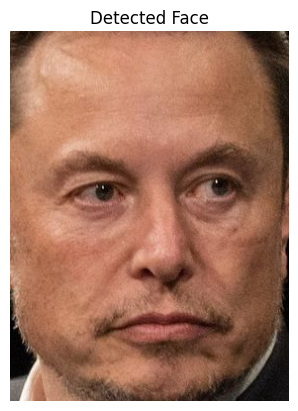

In [20]:
image1= cv2.imread(reference_image_path1)
faces = face_detector.detect_faces(image1)
show_detected_face(reference_image_path1, faces)

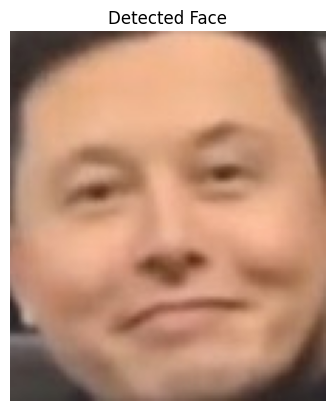

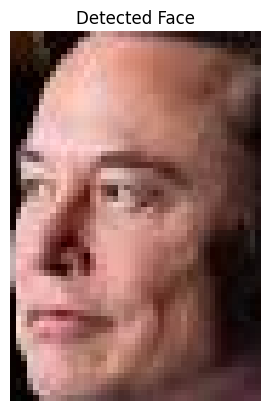

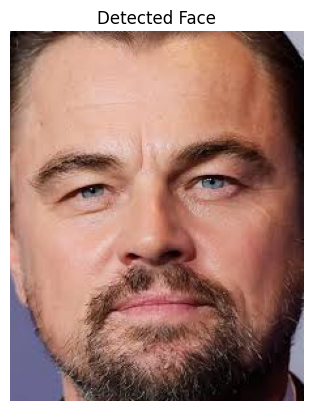

In [21]:
image2= cv2.imread(reference_image_path2)
faces = face_detector.detect_faces(image2)
show_detected_face(reference_image_path1, faces)

image3 = cv2.imread(reference_image_path3)
faces = face_detector.detect_faces(image3)
show_detected_face(reference_image_path1, faces)

image4 = cv2.imread(reference_image_path4)
faces = face_detector.detect_faces(image4)
show_detected_face(reference_image_path4, faces)

In [22]:
# Load known face images and extract embeddings
known_image_paths = ["/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/data/raw/pins_elon musk/elon musk101_1526.jpg",
                      "/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/data/processed/pins_Adriana Lima/Adriana Lima0_0_augmented_0.png",
                      "/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/data/processed/pins_Ben Affleck/Ben Affleck0_118_processed_0.png"]
known_faces = [get_embedding(loaded_model_keras, load_image(img_path)) for img_path in known_image_paths]
known_names = ["Elon Musk", "Adriana Lima", "Affleck"]




1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


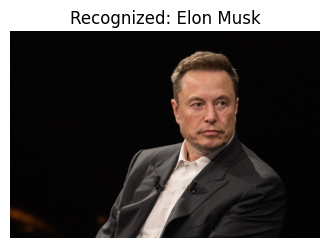

In [111]:
# Try Image one
test_face = load_image(reference_image_path1)
recognized_name = recognize_face(known_faces, known_names, test_face, loaded_model_keras)
visualize_recognition(test_face, recognized_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


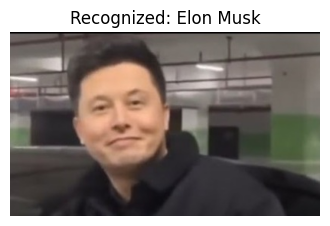

In [112]:
# Try Image 2
test_face = load_image(reference_image_path2)
recognized_name = recognize_face(known_faces, known_names, test_face, loaded_model_keras)
visualize_recognition(test_face, recognized_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


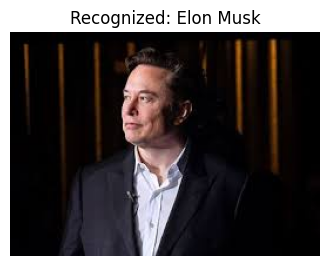

In [113]:
# Try Image 3
test_face = load_image(reference_image_path3)
recognized_name = recognize_face(known_faces, known_names, test_face, loaded_model_keras)
visualize_recognition(test_face, recognized_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


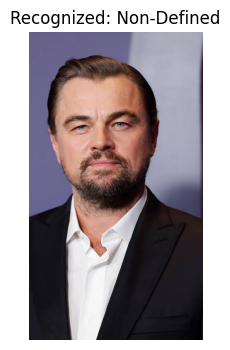

In [42]:
# Try Image 4
test_face = load_image(reference_image_path4)
recognized_name = recognize_face(known_faces, known_names, test_face, loaded_model_keras)
visualize_recognition(test_face, recognized_name)

In [23]:
# Create a connection to SQLite database
conn = sqlite3.connect('celebrity_embeddings.db')
cursor = conn.cursor()

In [24]:
# Create a table to store celebrity embeddings
cursor.execute("""
CREATE TABLE IF NOT EXISTS celebrity_embeddings (
    name TEXT PRIMARY KEY,
    embedding BLOB
)
""")
conn.commit()

# Close the database connection
conn.close()

In [25]:
def save_embeddings(celebrity_image_folder, model):
    """Save the embeddings of known faces in the database (only one image per celebrity)."""
    conn = sqlite3.connect('/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/celebrity_embeddings.db')
    cursor = conn.cursor()

    # Loop through the folders and process each celebrity
    for celebrity_name in os.listdir(celebrity_image_folder):
        celeb_folder_path = os.path.join(celebrity_image_folder, celebrity_name)

        if os.path.isdir(celeb_folder_path):  # Skip if it's not a directory
            # Process only the first image in the folder (one image per celebrity)
            image_name = os.listdir(celeb_folder_path)[0]  # Take the first image
            image_path = os.path.join(celeb_folder_path, image_name)

            try:
                image = load_image(image_path)  # Load the first image
                embedding = get_embedding(model, image)  # Get the embedding

                # Convert embedding to binary format
                embedding_binary = embedding.tobytes()

                # Insert into database (use INSERT OR REPLACE to ensure only one image per celebrity)
                cursor.execute("INSERT OR REPLACE INTO celebrity_embeddings (name, embedding) VALUES (?, ?)",
                               (celebrity_name, embedding_binary))
                conn.commit()
                print(f"Processed and saved embedding for {celebrity_name}")
            except Exception as e:
                print(f"Error processing {image_name} for {celebrity_name}: {e}")

    conn.close()


In [26]:
celebrity_image_folder = "/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/data/processed"
save_embeddings(celebrity_image_folder, loaded_model_keras)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Processed and saved embedding for pins_Alexandra Daddario
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Processed and saved embedding for pins_Adriana Lima
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Processed and saved embedding for pins_Alex Lawther
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Processed and saved embedding for pins_alycia dabnem carey
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
Processed and saved embedding for pins_amber heard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Processed and saved embedding for pins_Anne Hathaway
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Processed and saved embedding for pins_Andy Samberg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Processed and saved embedding for pins_Alvaro Morte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Processed and saved embedding for pins_Anthony Mackie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Processed and saved embedding for pins_Amanda Crew
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Processed and saved embedding for pin

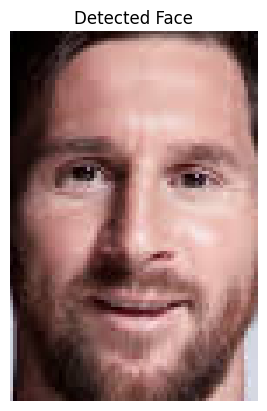

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Recognized as: pins_Lionel Messi


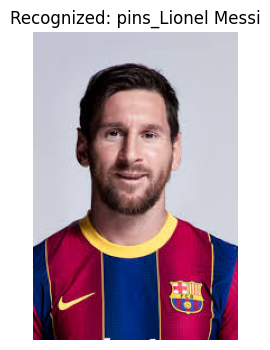

In [44]:
def load_saved_embeddings():
    """Load the celebrity embeddings from the database."""
    conn = sqlite3.connect('/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/celebrity_embeddings.db')
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM celebrity_embeddings")
    rows = cursor.fetchall()

    embeddings = {}
    for row in rows:
        name = row[0]
        embedding = np.frombuffer(row[1], dtype=np.float32)  # Convert from binary back to numpy array
        embeddings[name] = embedding

    conn.close()
    return embeddings

def recognize_face_db(test_image, known_embeddings, model, threshold=0.6):
    """Recognize the celebrity based on the test face image."""
    test_embedding = get_embedding(model, test_image)

    best_match = ('Non-Defined', 0)  # Default: No match
    for name, known_embedding in known_embeddings.items():
        is_match, similarity = compare_faces(known_embedding, test_embedding, threshold)
        if is_match and similarity > best_match[1]:
            best_match = (name, similarity)

    return best_match[0]

# Example: Load a test image and recognize the celebrity
test_image_path = "/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/data/CustomeImages/images (2).jpeg"
test_image = load_image(test_image_path)
# Show the image
image1= cv2.imread(test_image_path)
faces = face_detector.detect_faces(image1)
show_detected_face(test_image_path, faces)

# Load saved embeddings from the database
celebrity_embeddings = load_saved_embeddings()

# Recognize the celebrity
recognized_name = recognize_face_db(test_image, celebrity_embeddings, loaded_model_keras)
print(f"Recognized as: {recognized_name}")

# Show the image with recognizer
visualize_recognition(test_image, recognized_name)




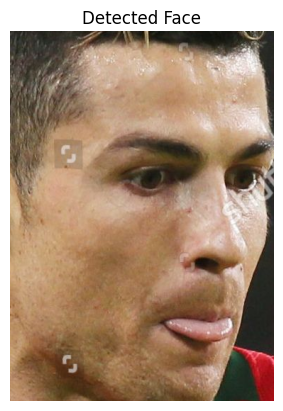

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Recognized as: pins_Cristiano Ronaldo


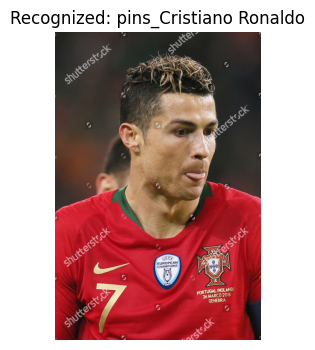

In [46]:
# Test Another Image
test_image_path = "/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/data/CustomeImages/cristiano-ronaldo-portugal-1500w-9478339fc.jpg"
test_image = load_image(test_image_path)
# Show the image
image1= cv2.imread(test_image_path)
faces = face_detector.detect_faces(image1)
show_detected_face(test_image_path, faces)

# Recognize the celebrity
recognized_name = recognize_face_db(test_image, celebrity_embeddings, loaded_model_keras)
print(f"Recognized as: {recognized_name}")

# Show the image with recognizer
visualize_recognition(test_image, recognized_name)

# Future Enhancements:
1. Introduce 'Unknown' Class:
  - It is important to add a dedicated 'unknown' class and utilize images specifically designed for celebrities
  - to reinforce this class and improve the model's robustness in identifying non-celebrity faces.
  -  This will be part of future work aimed at enhancing the model's classification performance.

2. Hyperparameter Optimization with Optuna:
  - Future work includes leveraging Optuna to perform hyperparameter optimization, focusing on critical
  - parameters such as the number of hidden layers and the number of hidden units per layer,
  - in order to fine-tune the model for optimal accuracy and performance in celebrity recognition tasks.
